# Identification of molecular families overrepresented in metabolites correlating with gestational age using hypergeometric testing

load libraries

In [1]:
import sys
import networkx as nx
import csv
import glob

import numpy as np
import pylab as plt

%matplotlib inline

## Load the edges

In [2]:
edge_file = glob.glob("GNPS_TopK2E5MaxComp0/networkedges_selfloop/*..selfloop")[0]
lines = []
with open(edge_file,'r') as f:
    reader = csv.reader(f,delimiter='\t')
    heads = next(reader)
    for line in reader:
        lines.append(line)

## Load the IDs that need to be checked

In [3]:
interesting_ids = {}
with open('LibrarySpectrumIDs.csv','r') as f:
    reader = csv.reader(f)
    heads = next(reader)
    for line in reader:
        interesting_ids[line[0]] = line[1]

## Load the correlations and selected features

In [4]:
node_p = {}
with open('../CorrelationAnalysis/KendallsTauCorrelation_pval_GA_1000Perm.txt','r') as f:
    reader = csv.reader(f,delimiter = '\t')
    heads = next(reader)
    for line in reader:
        node = int(line[2])
        if line[3] == "NA":
            pv = 0
        else:
            pv = int(line[3])
        node_p[node] = pv

## Load the spectral hits

In [5]:
hits_file = glob.glob("GNPS_TopK2E5MaxComp0/DB_result/*.tsv")[0]
hits = {}
ccms_name = {}
with open(hits_file,'r') as f:
    reader = csv.reader(f,delimiter = '\t')
    heads = next(reader)
    for line in reader:
        ccms = line[-4]
        if not ccms in ccms_name:
            ccms_name[ccms] = line[4]
        node_id = int(line[0])
        if not ccms in hits:
            hits[ccms] = set([node_id])
        else:
            hits[ccms].add(node_id)

In [7]:
# reverse dict
node_hits = {}
for ccms,nodes in hits.items():
    for node in nodes:
        if not node in node_hits:
            node_hits[node] = [ccms]
        else:
            node_hits[node].append(ccms)
            

## Make the graph

In [8]:
edge_threshold = 0.7
G = nx.Graph()
for line in lines:
    node1 = int(line[0])
    node2 = int(line[1])
    weight = float(line[4])
    if node1 in node_p and node2 in node_p and weight >= edge_threshold:
        G.add_edge(node1,node2,weight = weight)
        
all_nodes = G.nodes()
for node in node_p:
    if not node in all_nodes:
        G.add_edge(node,node,weight = 1)

## Work out the number at p<=0.05

130


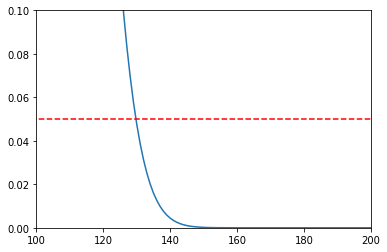

In [9]:
perc_chosen = 11.26
prob_choose = perc_chosen/100
from scipy.stats import binom
b = binom(1000,prob_choose)
probs = []
for i in np.arange(0,1000):
    probs.append((i,b.pmf(np.arange(i,1001)).sum()))
a,b = zip(*probs)
plt.plot(a,b)
plt.plot(plt.xlim(),[0.05,0.05],'r--')
plt.ylim([0,0.1])
plt.xlim([100,200])
plt.savefig('probs.png')
pos = np.where(np.array(b)<=0.05)[0][0]
sig_thresh = np.array(a)[pos]
print(sig_thresh) # number of times we need to see it out of 1000

In [10]:
k = list(node_p.keys())
v = list(node_p.values())
v = np.array(v)
vrandom = np.random.permutation(v)
node_p_random = {k:v for k,v in zip(k,vrandom)}

# total sig
tot_sig = sum([v >= sig_thresh for v in node_p.values()])
print(tot_sig)
tot_nodes = len(node_p)
print(tot_nodes)

1459
9010


In [11]:
from scipy.stats import hypergeom
import numpy as np
missing = []
nhg = []
for node in node_p:
    assert node in node_p
    n_neighbours = len(list(G.neighbors(node)))
    n_sig = sum([node_p[v] >= sig_thresh for v in G.neighbors(node)])
    M = tot_nodes
    if node_p[node] >= sig_thresh:
        n = tot_sig + 1 # include itself
        N = n_neighbours + 1 # include itself
    else:
        n = tot_sig
        N = n_neighbours
    rv = hypergeom(M,n,N)
    poss_sig = np.arange(n_sig,n+1)
    nhg.append((node,N,n_sig,(rv.pmf(poss_sig)).sum()))
        
nhg.sort(key = lambda x: x[-1])    
node_p_val_dict = {n:i for n,_,_,i in nhg}

In [12]:
missing = []
nhg_random = []
for node in node_p_random:
    assert node in node_p_random
    n_neighbours = len(list(G.neighbors(node)))
    n_sig = sum([node_p_random[v] >= sig_thresh for v in G.neighbors(node)])
    M = tot_nodes
    if node_p_random[node] >= sig_thresh:
        n = tot_sig + 1 # include itself
        N = n_neighbours + 1 # include itself
    else:
        n = tot_sig
        N = n_neighbours
    rv = hypergeom(M,n,N)
    poss_sig = np.arange(n_sig,n+1)
    nhg_random.append((node,N,n_sig,(rv.pmf(poss_sig)).sum()))
        
nhg_random.sort(key = lambda x: x[-1])

_,_,_,pv_random = zip(*nhg_random)
_,_,_,pv = zip(*nhg)

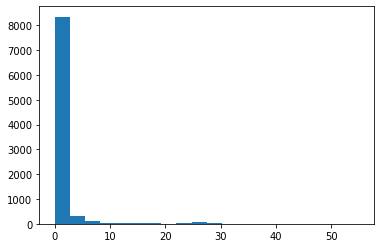

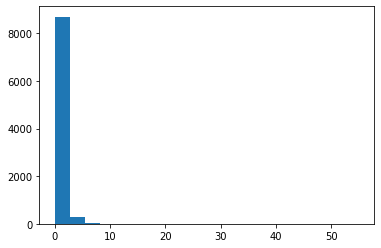

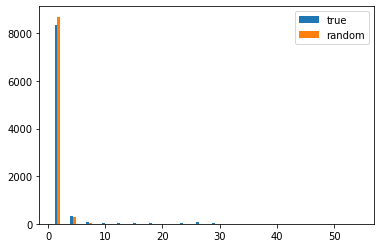

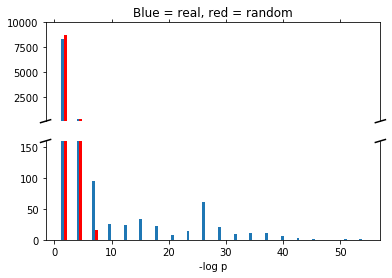

In [13]:
import pylab as plt
%matplotlib inline
bw = 0.5
b = plt.hist(-np.log(pv),bins=20)
plt.figure()
a = plt.hist(-np.log(pv_random),bins = b[1])
plt.figure()
bin_cents = (b[1][:-1] + b[1][1:])/2
plt.bar(bin_cents,b[0],width=bw,label = 'true')
plt.bar(bin_cents+bw,a[0],width=bw,label='random')
plt.legend()
# plt.ylim([0,50])

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
# plot the same data on both axes
ax.bar(bin_cents,b[0],width=bw,label = 'true')
ax.bar(bin_cents+bw,a[0],width=bw,label='random',color = [1,0,0])

ax2.bar(bin_cents,b[0],width=bw,label = 'true')
ax2.bar(bin_cents+bw,a[0],width=bw,label='random',color = [1,0,0])

l = 160
ll = 100
ax2.set_ylim(0,l)
ax.set_ylim(ll,10000)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.set_xlabel('-log p')
ax.set_title('Blue = real, red = random')
plt.savefig('test.png')

## Make output file


In [14]:
with open('output.csv','w') as f:
    writer = csv.writer(f)
    heads = ['node','sig','p_neigh','sig_neigh','hits']
    writer.writerow(heads)
    for node,p in node_p.items():
        new_row = [node]
        new_row.append(p>=sig_thresh)
        new_row.append(node_p_val_dict[node])
        new_row.append(node_p_val_dict[node]<=0.05)
        if node in node_hits:
            new_row.append(';'.join(["({}:{})".format(c,ccms_name[c]) for c in node_hits[node]]))
        else:
            new_row.append('')
        writer.writerow(new_row)